In [6]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict

import os, sys
from google.colab import drive
drive.mount("/content/drive/")
os.chdir("/content/drive/My Drive/chess_app_testing")
sys.path.append("/content/drive/My Drive/chess_app_testing")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [96]:
# Read image and do lite image processing
def read_img(file, crop=None):
    """
    crop = (x1,x2,y1,y2)

    """
    img = cv2.imread(str(file))
    if crop!=None:
      img = img[crop[2]:crop[3],crop[0]:crop[1]]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.blur(gray, (5, 5))
    return img, gray_blur


# Canny edge detection
def canny_edge(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(img, lower, upper)
    return edges


# Hough line detection
def hough_line(edges, min_line_length=100, max_line_gap=10):
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 125, min_line_length, max_line_gap)
    lines = np.reshape(lines, (-1, 2))
    return lines


# Separate line into horizontal and vertical
def h_v_lines(lines):
    h_lines, v_lines = [], []
    for rho, theta in lines:
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v_lines.append([rho, theta])
        else:
            h_lines.append([rho, theta])
    return h_lines, v_lines


# Find the intersections of the lines
def line_intersections(h_lines, v_lines):
    points = []
    for r_h, t_h in h_lines:
        for r_v, t_v in v_lines:
            a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
            b = np.array([r_h, r_v])
            inter_point = np.linalg.solve(a, b)
            points.append(inter_point)
    return np.array(points)


# Hierarchical cluster (by euclidean distance) intersection points
def cluster_points(points):
    dists = spatial.distance.pdist(points)
    single_linkage = cluster.hierarchy.single(dists)
    flat_clusters = cluster.hierarchy.fcluster(single_linkage, 15, 'distance')
    cluster_dict = defaultdict(list)
    for i in range(len(flat_clusters)):
        cluster_dict[flat_clusters[i]].append(points[i])
    cluster_values = cluster_dict.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), cluster_values)
    return sorted(list(clusters), key=lambda k: [k[1], k[0]])


# Average the y value in each row and augment original points
def augment_points(points):
    points_shape = list(np.shape(points))
    augmented_points = []
    for row in range(int(points_shape[0] / 11)):
        start = row * 11
        end = (row * 11) + 10
        rw_points = points[start:end + 1]
        rw_y = []
        rw_x = []
        for point in rw_points:
            x, y = point
            rw_y.append(y)
            rw_x.append(x)
        y_mean = np.mean(rw_y)
        for i in range(len(rw_x)):
            point = (rw_x[i], y_mean)
            augmented_points.append(point)
    augmented_points = sorted(augmented_points, key=lambda k: [k[1], k[0]])
    return augmented_points


In [100]:
img, gray_blur = read_img('lichess.jpg')
# Canny algorithm
edges = canny_edge(gray_blur, sigma = 0.4)
# Hough Transform
lines = hough_line(edges)
# Separate the lines into vertical and horizontal lines
h_lines, v_lines = h_v_lines(lines)
# Find and cluster the intersecting
intersection_points = line_intersections(h_lines, v_lines)
points = cluster_points(intersection_points)
# Final coordinates of the board
points = augment_points(points)


In [101]:
points_x = [point[0] for point in points]
points_y = [point[1] for point in points]

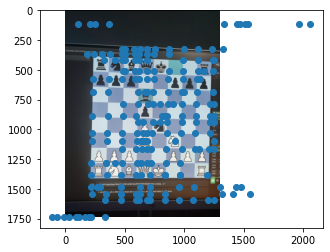

In [103]:
plt.imshow(img)
plt.scatter(points_x, points_y)


In [112]:
def get_diagram_position(image):
    #assert isinstance(image, (np.ndarray, np.generic)), "image must be a numpy array"

    # get the minimum bounding box for the chip image
    image = np.array(cv2.imread(str(image))[..., :3])
    image = image[10:-10, 10:-10]
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)[..., 0]
    ret, thresh = cv2.threshold(imgray, 20, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    mask = 255 - thresh
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    max_area = 0
    best = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            best = contour

    rect = cv2.minAreaRect(best)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # crop image inside bounding box
    scale = 1  # cropping margin, 1 == no margin
    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    angle = rect[2]
    rotated = False
    if angle < -45:
        angle += 90
        rotated = True

    center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    size = (int(scale * (x2 - x1)), int(scale * (y2 - y1)))

    M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1.0)

    cropped = cv2.getRectSubPix(image, size, center)
    cropped = cv2.warpAffine(cropped, M, size)

    croppedW = W if not rotated else H
    croppedH = H if not rotated else W

    image = cv2.getRectSubPix(
        cropped, (int(croppedW * scale), int(croppedH * scale)), (size[0] / 2, size[1] / 2))

    return image
def split(d: int) -> list:
    result = [0]
    i: int = d // 8
    r: int = d % 8
    for k in range(8):
        if r > 0:
            result.append((k + 1) * i + 1)
            r -= 1
        else:
            result.append((k + 1) * i)

    return result
    
def get_squares(diagram):
    height, width, channels = diagram.shape

    # lists with 9 elements each ( (begin,end) pairs )
    h_list = split(height)
    w_list = split(width)

    black_squares = []
    white_squares = []

    for i in range(8):
        for j in range(8):
            elem = diagram[h_list[i]:h_list[i+1], w_list[j]:w_list[j+1]]
            if (i + j) % 2 == 1:
                black_squares.append((elem, j, i))
            else:
                white_squares.append((elem, j, i))
                
    return black_squares, white_squares

In [113]:
black_squares, white_squares = get_squares(get_diagram_position("lichess.jpg"))

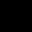

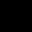

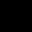

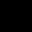

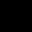

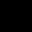

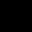

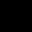

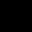

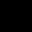

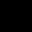

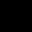

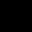

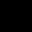

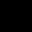

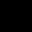

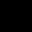

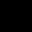

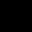

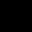

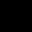

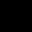

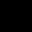

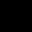

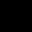

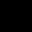

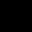

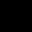

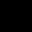

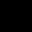

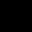

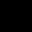

In [115]:
for image, i, j in black_squares:
            image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            square = cv.resize(image_gray, (32, 32)) / 255.0
            cv2_imshow(square)